# 智能家居应用

虚谷号能通过Arduino控制LED灯，但是能否控制如电灯、电风扇、电视机之类的220V家用电器？听起来有点不可思议，其实答案是肯定的。我们甚至可以用虚谷号控制家里的所有用电器，实现智能家居。

## 传统家居和智能家居

智能家居是以住宅为平台，兼备建筑、网络通信、信息家电、设备自动化，集系统、结构、服务、管理为一体的高效、舒适、安全、便利、环保的居住环境。1984年，世界上第一幢智能建筑在美国出现后，加拿大、欧洲、澳大利亚和东南亚等经济比较发达的国家先后提出了各种智能家居的方案。现在，智能家居技术在美国、德国、新加坡、日本等国家都有广泛应用。

智能家居和传统家居的最大区别在于用电器的开关控制，由过去的人工手控，变成用电脑智能控制。传统家居电路如图所示，是通过直接控制开关的形式来控制灯光（家用电器）。

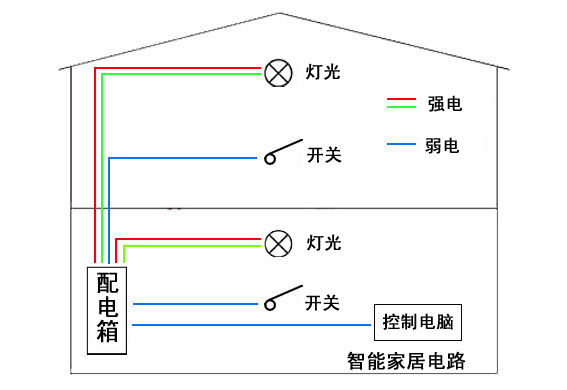

传统家居电路（以灯光为例）

而智能家居电路中，控制电脑和开关、灯光（家用电器）都连到配电箱，是通过电脑使用弱电（蓝线）控制开关的形式，以达到控制灯光（家用电器）的目的，如图所示。

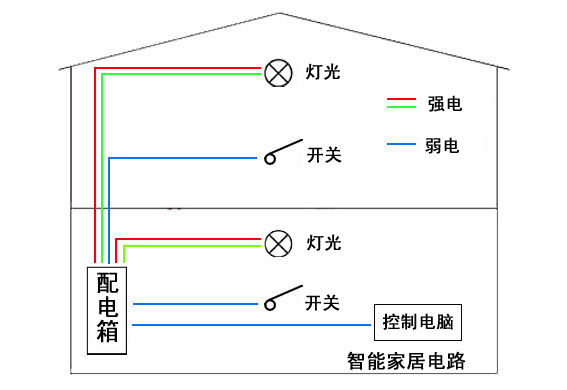

智能家居电路示意图（以灯光为例）

## 智能家居范例

1.功能描述：利用虚谷号和常见传感器模块，制作一个简单的物联网作品原型，实现数据采集和远程控制，并且可以和手机交互；

2.涉及材料：
    - 虚谷号
    - Arduino扩展板
    - 光线传感器
    - 继电器模块

3.参考网站：https://github.com/vvlink/SIoT

**继电器介绍**

继电器（relay）是一种当输入量的变化达到规定要求时，在电气输出电路中使被控量发生预定变化的电控制器件。继电器通常应用于自动化的控制电路中，它实际上是用弱电控制强电的一种“自动开关”，在电路中起着自动调节、安全保护、转换电路等作用。为控制大电流电器，很多创客企业都设计了继电器模块。

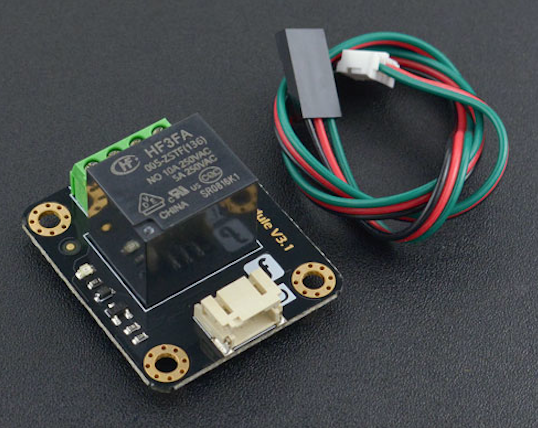

## 编写范例

### 1.采集传感器数据

第一步：导入库

In [ ]:
import siot
import time

siot库是对mqtt库对二次封装，让代码更加简洁。

In [ ]:
from xugu import Pin

xugu库是转为虚谷号开发的通用GPIO库，通过串口控制虚谷号板载的Arduino。第一次引入这个库，虚谷号将会给板载Arduino写入标准的固件。

In [ ]:
SERVER = "127.0.0.1"        #MQTT服务器IP
CLIENT_ID = ""              #在SIoT上，CLIENT_ID可以留空
IOT_pubTopic  = 'xzr/001'   #“topic”为“项目名称/设备名称”
IOT_UserName ='scope'        #用户名
IOT_PassWord ='scope'     #密码

说明：虚谷号可以用127.0.0.1表示本机，用户名和密码统一使用“scope”，topicid自己定义，这里用的是“xzr/001”，表示项目名称为“xzr”，设备名称为“001”。

第三步：连接SIOT服务器

In [ ]:
siot.init(CLIENT_ID, SERVER, user=IOT_UserName, password=IOT_PassWord)
siot.connect()

第四步：初始化模拟传感器

In [ ]:
p1 = Pin("A0", Pin.ANALOG) # 初始化 A0 引脚,设置为输入模式

请将光线传感器通过arduino扩展板（通用），接到虚谷号板载Arduino的A0口。

第五步：获取模拟传感器数据，并发送MQTT消息

In [ ]:
while True:
  value = p1.read_analog()
  print(value)
  siot.publish(IOT_pubTopic,"%d"%value)
  time.sleep(1)

访问虚谷号的siot服务，输入用户名密码（分别为scope），在主题“xzr/001”中，可看到虚谷号发送的光线数据，如图所示。
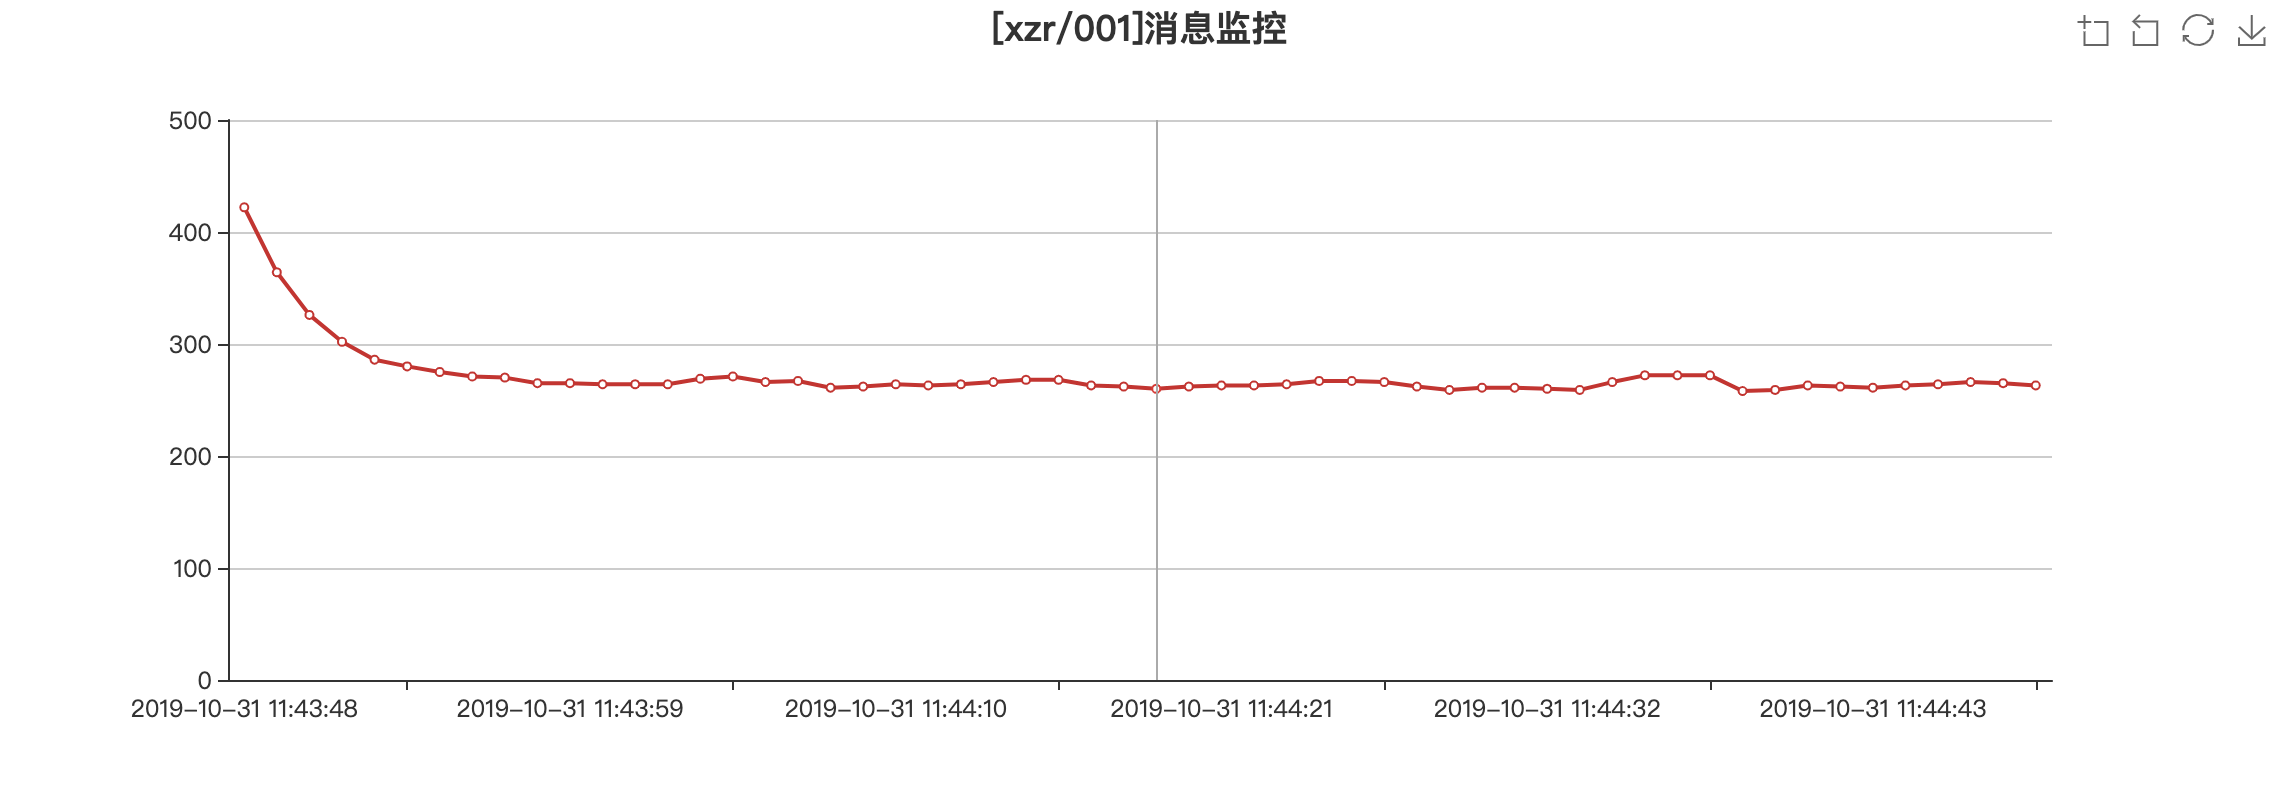

注：使用“中断服务”按钮（上方的黑色正方形），可以停止程序运行。

### 2.远程控制虚谷号继电器

前三步和第一个案例是一样的，这里直接从第四步开始。同时，为了和上一个范例的数据隔离，这里使用了一个新的topicid（主题），名称为“xzr/002”。继电器模块接在13号引脚。

In [ ]:
IOT_pubTopic  = 'xzr/002'   # “topic”为“项目名称/设备名称”
p = Pin(13, Pin.OUT)

第四步：定义全局变量

利用第五步的回调函数，当接收到信息的时候，就给全局变量ret赋值。

In [ ]:
ret = 0

第五步：构建订阅信息的回调函数

In [ ]:
def sub_cb(client, userdata, msg):
  global ret
  print("\nTopic:" + str(msg.topic) + " Message:" + str(msg.payload))
  if msg.payload==b'1':
    ret = 1
  if msg.payload==b'0':
    ret = 0

第六步：开始订阅信息

In [ ]:
siot.subscribe(IOT_pubTopic, sub_cb)
siot.loop()

第七步：循环监视变量，并控制LED

In [ ]:
while True:
  if ret == 1:
    p.write_digital(1)
  if ret == 0:
    p.write_digital(0)

##注：如果打开笔记的时候，程序已经运行，需先选择上方“服务”->再选择“重启 & 清空输出”，便可重新运行程序

运行到这里，请打开siot的web管理页面，在“发送消息”页面，给主题“xzr/002”发送信息，发送“1”和“0”，会听到继电器模块发出“开”和“断”的声音。

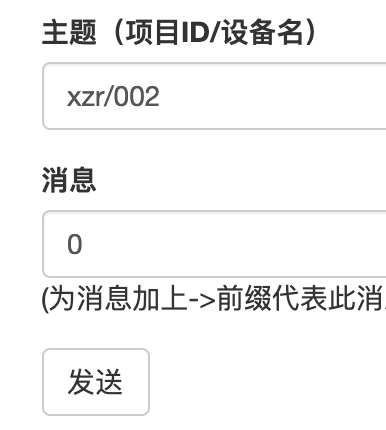

同时，jupyter页面上将看到输出的信息。回调函数sub_cb中收到消息将会打印出来。


## 问题回答

1.如果想实现外网控制，该怎么做？
    
    1）代码中的muqtt服务器改为easyiot或者阿里云，topicid、用户名、密码都同步修改。那么数据就直接发送到easyiot或者阿里云的服务器了。
    2）利用路由器的端口映射或者DMZ主机功能，将外网的ip映射到虚谷号上。

2.能不能做到虚谷号开机后，Python程序自动运行呢？

    将Python代码保存在U盘目录（vvBoard）的Python文件夹中，名字改为main.py，用主机模式启动。
    
3.可以用掌控板开控制虚谷号的继电器模块吗？
    
    当然可以，只要能够上网并且运行MQTT协议的硬件，都可以控制。
